In [31]:
from reshape_base_algos.body_retoucher import BodyRetoucher
import time
import cv2
import argparse
import numpy as np
import glob
import tqdm
import os
import json
import shutil
from utils.eval_util import cal_lpips_and_ssim, psnr
from config.test_config import TESTCONFIG, load_config
import toml
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
with open('config/test_hp_setting.toml') as f:
    load_config(toml.load(f))

In [3]:
ret = BodyRetoucher.init(reshape_ckpt_path=TESTCONFIG.reshape_ckpt_path,
                            pose_estimation_ckpt=TESTCONFIG.pose_estimation_ckpt,
                            device=0, log_level='error',
                            log_path='test_log.txt',
                            debug_level=1)

In [4]:
src_img = cv2.imread('/data/samples/input2_low.jpg')

In [5]:
pred, flow = BodyRetoucher.reshape_body(src_img, degree=-1.0)

    [] human_joint_box: [256, 797, 170, 570]
    [] human_box: [121, 798, 35, 598]
    [] leg_joint_box: [256, 797, 170, 480]
    [] leg_box: [121, 798, 35, 598]
    [] arm_joint_box: [290, 434, 269, 570]
    [] arm_box: [260, 464, 239, 600]
    [] arm_box1: [260, 464, 239, 600]
    [] arm_box2: [188, 536, 167, 598]
    [] roi_bbox: [188, 536, 167, 598]
    [] arm_box1: [260, 464, 239, 600]
    [] arm_box2: [188, 536, 167, 598]
    [] roi_bbox: [121, 798, 35, 598]
    [] arm_box1: [260, 464, 239, 600]
    [] arm_box2: [1, 798, 1, 598]
    [] roi_bbox: [121, 798, 35, 598]


/data/miniconda3/envs/osx/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/miniconda3/envs/osx/lib/python3.8/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [6]:
src_img.shape

(800, 600, 3)

In [7]:
flow.shape

(800, 600, 2)

In [18]:
rDx = np.ascontiguousarray(flow[..., 0])
rDy = np.ascontiguousarray(flow[..., 1])

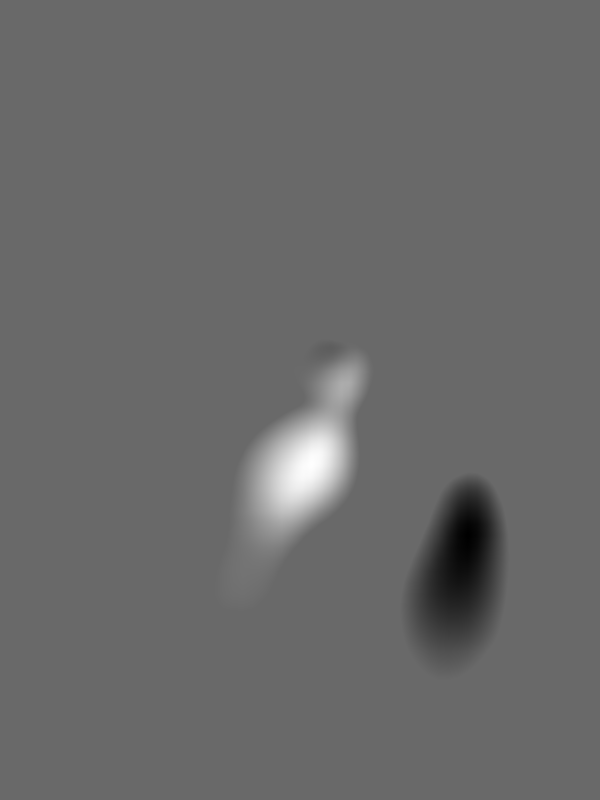

In [23]:
Image.fromarray(cv2.normalize(rDx, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

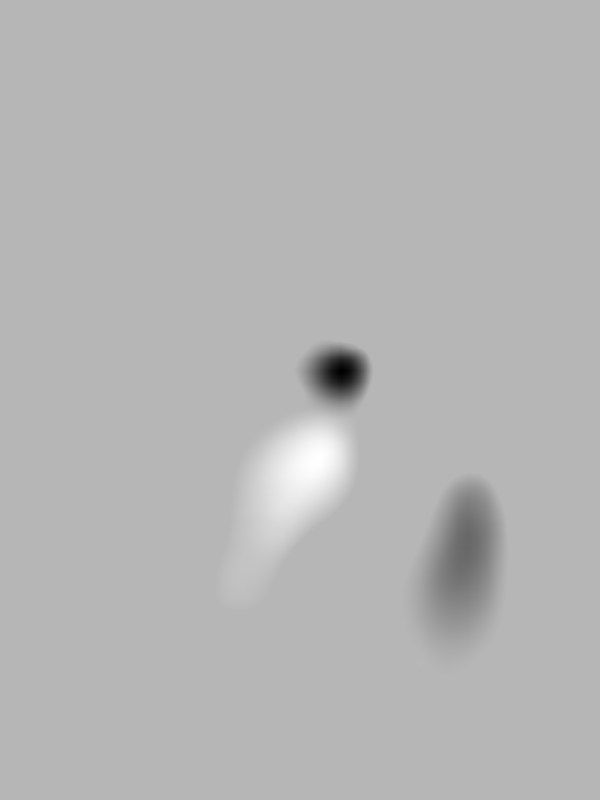

In [24]:
Image.fromarray(cv2.normalize(rDy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

In [25]:
mag, ang = cv2.cartToPolar(rDx, rDy)

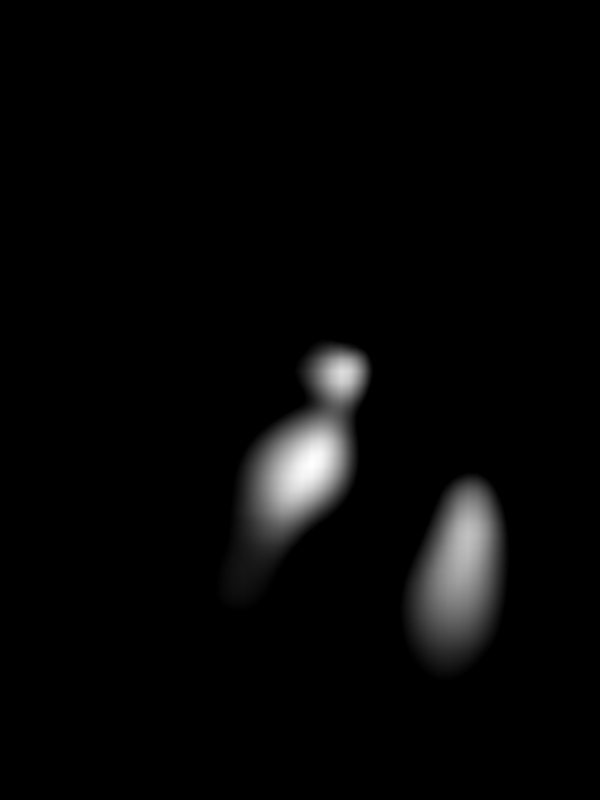

In [29]:
Image.fromarray(cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

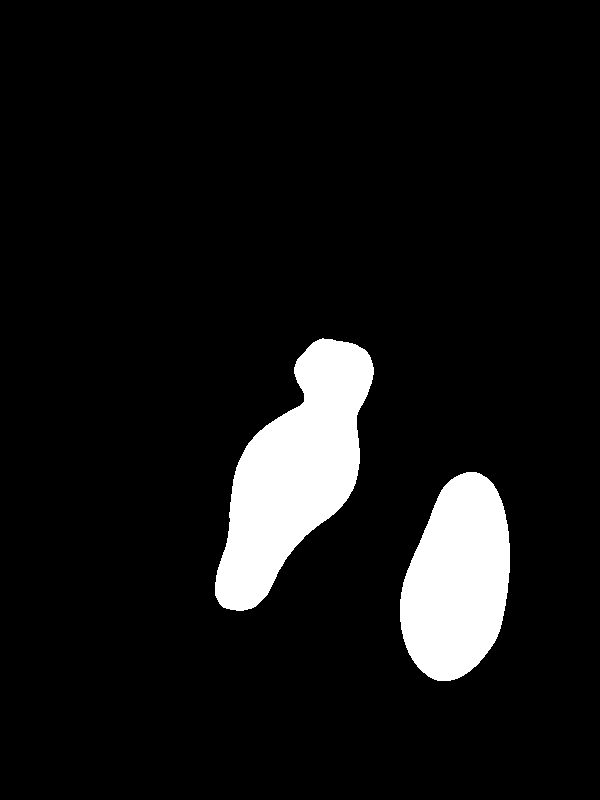

In [52]:
Image.fromarray(cv2.normalize((mag > 0).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

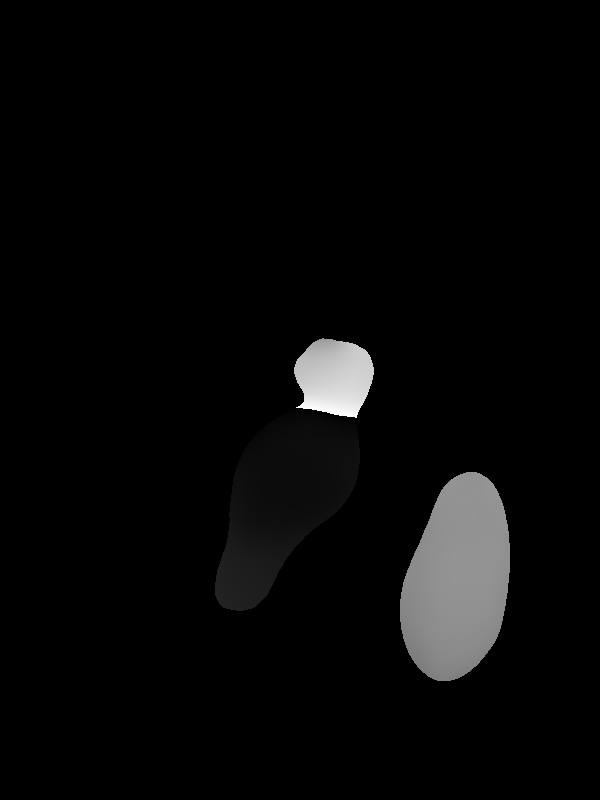

In [30]:
Image.fromarray(cv2.normalize(ang, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

In [33]:
fig = plt.figure()
fig.ax

<Figure size 640x480 with 0 Axes>

In [36]:
src_img.shape

(800, 600, 3)

In [54]:
ix, iy = np.where(mag>0)

    [] human_joint_box: [256, 797, 170, 570]
    [] human_box: [121, 798, 35, 598]
    [] leg_joint_box: [256, 797, 170, 480]
    [] leg_box: [121, 798, 35, 598]
    [] arm_joint_box: [290, 434, 269, 570]
    [] arm_box: [260, 464, 239, 600]
    [] arm_box1: [260, 464, 239, 600]
    [] arm_box2: [188, 536, 167, 598]
    [] roi_bbox: [188, 536, 167, 598]
    [] arm_box1: [260, 464, 239, 600]
    [] arm_box2: [188, 536, 167, 598]
    [] roi_bbox: [121, 798, 35, 598]
    [] arm_box1: [260, 464, 239, 600]
    [] arm_box2: [1, 798, 1, 598]
    [] roi_bbox: [121, 798, 35, 598]


/data/miniconda3/envs/osx/lib/python3.8/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


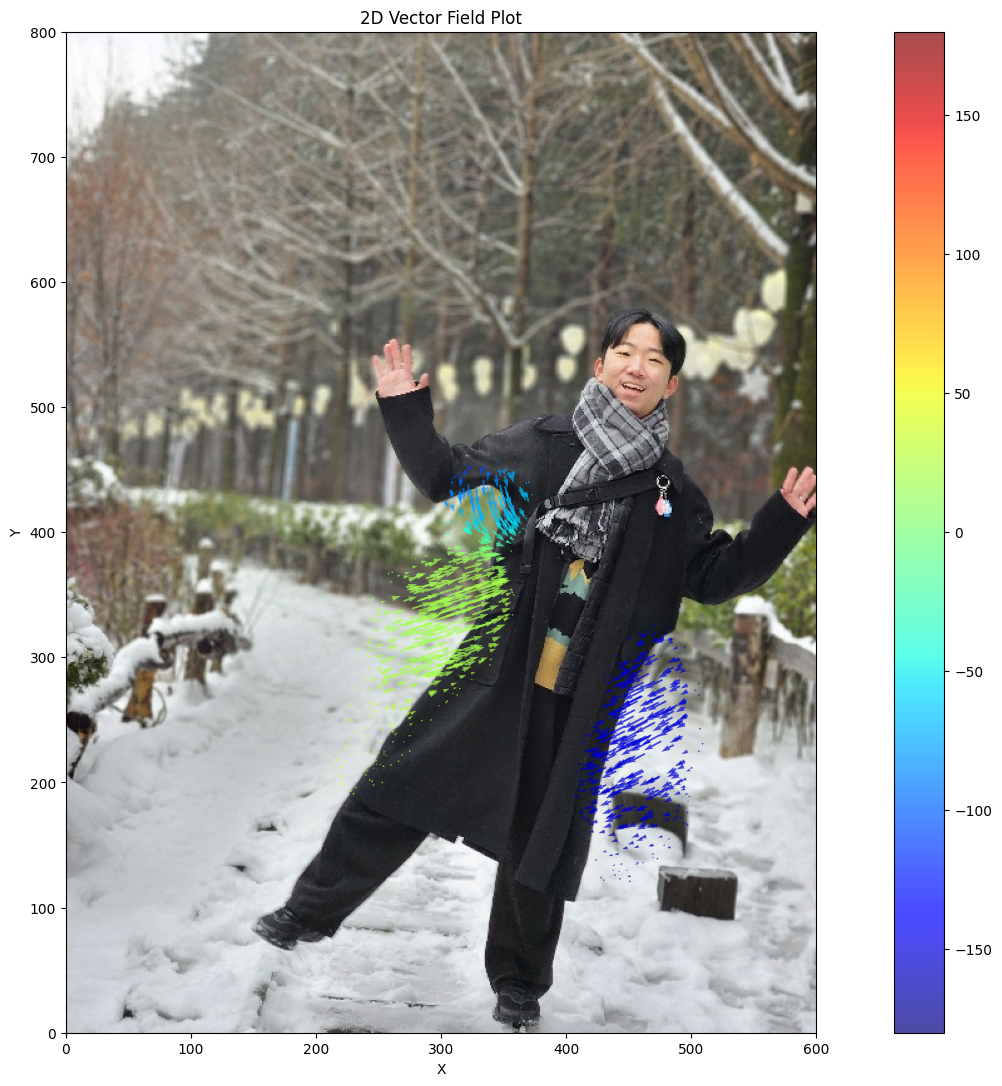

In [188]:
pred, flow = BodyRetoucher.reshape_body(src_img, degree=3.0)
rDx = np.ascontiguousarray(flow[..., 0])
rDy = np.ascontiguousarray(flow[..., 1])
mag, ang = cv2.cartToPolar(rDx, rDy)

# 그리드 생성
H, W, _ = src_img.shape
x = np.linspace(0, W-1, W) # x 좌표 범위
y = np.linspace(0, H-1, H) # y 좌표 범위
X, Y = np.meshgrid(x, y) # 그리드 생성
X = X[mag>0][:]
Y = np.flipud(Y)[mag>0][:]

rand_idx = np.random.permutation(len(X))[:800]

# 벡터 필드 생성 (예시로 간단한 경우)
U = -rDx[mag>0][:]
V = -rDy[mag>0][:]

E = np.arctan2(V, U) * 180 / np.pi

rand_idx = np.random.permutation(len(X))[:800]

# 벡터 필드 플롯
plt.figure(figsize=(13,13))
# plt.imshow(np.flipud(src_img)[..., ::-1])
plt.imshow(np.flipud(pred)[..., ::-1])
qq = plt.quiver(X[rand_idx], Y[rand_idx], U[rand_idx], V[rand_idx], E[rand_idx], scale=H, cmap=plt.cm.jet, alpha=0.7)
plt.colorbar(qq, cmap=plt.cm.jet)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Vector Field Plot')

# x축 범위 제한
plt.axis('scaled')
plt.xlim(0, W)
plt.ylim(0, H)
plt.clim(-180, 180)

# plt.axis()

# plt.grid()
plt.show()